# Config

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import scanpy as sc
import torch
import scipy.spatial
import ot
import matplotlib.patches as mpatches
import string

from omegaconf import OmegaConf
import pytorch_lightning as pl

In [3]:
DATA_PATH = '/braid/havivd/scgen/kang.h5ad'
MODEL_PATH = '/braid/havivd/scgen/kang_model_params.pth'
USE_SAVED_MODEL = False
OVERWRITE_SAVED_MODEL = False
CONCEPT_KEY = 'concepts'
RANDOM_SEED = 5

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
# --- Plotting Configuration ---
CT_CMAP = {
    'B cells': "#e91111", 'CD4 T cells': '#048757', 'CD8 T cells': '#9cdb97',
    'CD14+ Monocytes': '#90e0ef', 'Dendritic cells': '#ffb72a',
    'FCGR3A+ Monocytes': '#b18bda', 'Megakaryocytes': '#c5c5b6', 'NK cells': '#51696c'
}
STIM_CMAP = {'ctrl': '#fcb6b1', 'stim': '#c44536'}
IDENT_CMAP = {
    'train': '#676765', 'held out for intervention': '#c84639',
    'held out as GT': '#048757', 'intervened on': '#06d400'
}
TITLE_MAP = {'cell': 'Cell Type', 'stim': 'State', 'ident': 'Split'}

# DATA LOADING AND PREPARATION

In [ ]:
def split_data_for_counterfactuals(adata, hold_out_label, mod_label, p_intervention=0.2):
    """Splits data into train, intervention, and ground truth sets."""
    print("Splitting data for counterfactual experiment...")
    labels = adata.obs['cell_stim']
    is_test = (labels == hold_out_label)
    is_inter_pool = (labels == mod_label)

    # Create a random mask to select a subset for intervention
    inter_mask = np.random.binomial(1, p=p_intervention, size=is_inter_pool.sum()).astype(bool)
    is_inter = np.zeros_like(labels, dtype=bool)
    is_inter[is_inter_pool] = inter_mask
    
    is_train = ~is_test & ~is_inter

    # Create AnnData objects for each split
    adata_train = adata[is_train].copy()
    adata_test = adata[is_test].copy()
    adata_inter = adata[is_inter].copy()

    # Store split identifiers in the original object for later merging
    ident_vec = np.array(['train'] * len(adata)).astype('<U32')
    ident_vec[is_test] = 'held out as GT'
    ident_vec[is_inter] = 'held out for intervention'
    adata.obs['ident'] = ident_vec
    
    print(f"Train set: {len(adata_train)} cells")
    print(f"Intervention set: {len(adata_inter)} cells")
    print(f"Ground Truth set: {len(adata_test)} cells")

    return adata, adata_train, adata_test, adata_inter


# MODELING & PREDICTION METHODS

## Method 1: scCBGM

In [ ]:


def train_method_1_cbgm(adata_train):
    """Trains and returns the scCBGM model."""
    print("Training scCBGM model...")
    config = OmegaConf.create(dict(
        has_cbm=True, lr=5e-4, hidden_dim=256, beta=1e-5,
        input_dim=adata_train.shape[1], latent_dim=128,
        n_concepts=adata_train.obsm[CONCEPT_KEY].shape[1],
        min_bottleneck_size=128, independent_training=True,
        concepts_hp=0.005, orthogonality_hp=0.2, use_soft_concepts=False
    ))
    model = clab.models.scCBGM(config)

    data_module = clab.data.dataloader.GeneExpressionDataModule(
        adata_train, add_concepts=True, concept_key=CONCEPT_KEY, batch_size=512, normalize=False
    )
    trainer = pl.Trainer(max_epochs=200, log_every_n_steps=10, accelerator='auto')
    trainer.fit(model, data_module)

    return model.to("cpu").eval()

def predict_with_method_1_cbgm(model, adata_inter, hold_out_label):
    """Performs intervention using a trained scCBGM model."""
    print("Performing intervention with scCBGM...")
    x_intervene_on = torch.tensor(adata_inter.X.toarray(), dtype=torch.float32)
    c_intervene_on = adata_inter.obsm[CONCEPT_KEY].to_numpy().astype(np.float32)

    # Define the intervention by creating a mask and new concept values
    mask = torch.zeros(c_intervene_on.shape, dtype=torch.float32)
    mask[:, -1] = 1  # Intervene on the last concept (stim)
    
    inter_concepts = torch.tensor(c_intervene_on, dtype=torch.float32)
    inter_concepts[:, -1] = 1 # Set stim concept to 1

    with torch.no_grad():
        inter_preds = model.intervene(x_intervene_on, mask=mask, concepts=inter_concepts)
    
    x_inter_preds = inter_preds['x_pred'].cpu().numpy()

    pred_adata = ad.AnnData(x_inter_preds, var=adata_inter.var)
    pred_adata.obs['ident'] = 'intervened on'
    pred_adata.obs['cell_stim'] = hold_out_label + '*'
    return pred_adata


##  Method 2: Flow Matching with Learned Concepts

In [7]:
def get_learned_concepts(scCBGM_model, adata_full):
    """Uses a trained scCBGM to generate learned concepts for all data."""
    print("Generating learned concepts from scCBGM...")
    with torch.no_grad():
        all_x = torch.tensor(adata_full.X.toarray(), dtype=torch.float32)
        enc = scCBGM_model.encode(all_x)
        adata_full.obsm['scCBGM_concepts_known'] = scCBGM_model.cb_concepts_layers(enc['mu']).cpu().numpy()
        adata_full.obsm['scCBGM_concepts_unknown'] = scCBGM_model.cb_unk_layers(enc['mu']).cpu().numpy()
    return adata_full

def train_method_2_fm_learned(adata_train, pc = False):
    """Trains and returns the CB-FM model using learned concepts."""
    print("Training CB-FM model with learned concepts...")

    if(pc):
        data_matrix = adata_train.uns['pca_transform'].transform(adata_train.X.toarray())
    else:
        data_matrix = adata_train.X.toarray()

    fm_model = clab.models.cb_fm.CB_FM(
        x_dim=data_matrix.shape[1],
        c_known_dim=adata_train.obsm['scCBGM_concepts_known'].shape[1],
        c_unknown_dim=adata_train.obsm['scCBGM_concepts_unknown'].shape[1],
        emb_dim=1024, n_layers=6
    )
    fm_model.train(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts_known=torch.from_numpy(adata_train.obsm['scCBGM_concepts_known'].astype(np.float32)),
        concepts_unknown=torch.from_numpy(adata_train.obsm['scCBGM_concepts_unknown'].astype(np.float32)),
        num_epochs=1000, batch_size=128, lr=3e-4, p_drop=0.1
    )
    return fm_model

# def predict_with_method_2_fm_learned(model, adata_inter, hold_out_label, pc = False):
#     """Performs intervention using a trained learned-concept CB-FM model."""
#     print("Performing intervention with CB-FM (learned)...")
#     c_known_inter = torch.from_numpy(adata_inter.obsm['scCBGM_concepts_known'].astype(np.float32))
#     c_unknown_inter = torch.from_numpy(adata_inter.obsm['scCBGM_concepts_unknown'].astype(np.float32))
    
#     inter_concepts_known = c_known_inter.clone()
#     inter_concepts_known[:, -1] = 1 # Set stim concept to 1
    
#     inter_preds = model.sample(
#         concepts_known=inter_concepts_known,
#         concepts_unknown=c_unknown_inter,
#         negative_concepts_known=c_known_inter,
#         num_samples=inter_concepts_known.shape[0],
#         timesteps=1000, w_pos=1.2, w_neg=1.0
#     )
#     x_inter_preds = inter_preds.detach().cpu().numpy()

#     if(pc == True):
#         x_inter_preds = adata_inter.uns['pca_transform'].inverse_transform(x_inter_preds)

#     pred_adata = ad.AnnData(x_inter_preds, var=adata_inter.var)
#     pred_adata.obs['ident'] = 'intervened on'
#     pred_adata.obs['cell_stim'] = hold_out_label + '*'
#     return pred_adata

def predict_with_method_2_fm_learned(model, adata_inter, hold_out_label, pc = False):
    """Performs intervention using a trained learned-concept CB-FM model."""
    print("Performing intervention with CB-FM (learned)...")
    c_known_inter = torch.from_numpy(adata_inter.obsm['scCBGM_concepts_known'].astype(np.float32))
    c_unknown_inter = torch.from_numpy(adata_inter.obsm['scCBGM_concepts_unknown'].astype(np.float32))
    
    inter_concepts_known = c_known_inter.clone()
    inter_concepts_known[:, -1] = 1 # Set stim concept to 1
    
    if(pc):
        x_inter = adata_inter.uns['pca_transform'].transform(adata_inter.X.toarray())
    else:
        x_inter = adata_inter.X.toarray()

    inter_preds = model.edit(
        x_orig =torch.from_numpy(x_inter.astype(np.float32)),
        timesteps = 1000,
        t_edit = 0.1,
        w_cfg = 1.2,
        noise_scale = 0.3,
        orig_concepts_known = c_known_inter,
        orig_concepts_unknown = c_unknown_inter,
        cf_concepts_known = inter_concepts_known,
        cf_concepts_unknown = c_unknown_inter
    )
    x_inter_preds = inter_preds.detach().cpu().numpy()

    if(pc == True):
        x_inter_preds = adata_inter.uns['pca_transform'].inverse_transform(x_inter_preds)

    pred_adata = ad.AnnData(x_inter_preds, var=adata_inter.var)
    pred_adata.obs['ident'] = 'intervened on'
    pred_adata.obs['cell_stim'] = hold_out_label + '*'
    return pred_adata




## Method 3: Flow Matching with Raw Concepts 

In [8]:

def train_method_3_fm_raw(adata_train, pc = False):
    """Trains and returns the CB-FM model using learned concepts."""
    print("Training CB-FM model with learned concepts...")

    if(pc):
        data_matrix = adata_train.uns['pca_transform'].transform(adata_train.X.toarray())
    else:
        data_matrix = adata_train.X.toarray()
    print("Training CB-FM model with raw concepts...")
    fm_model_raw = clab.models.cb_fm.CB_FM(
        x_dim=data_matrix.shape[1],
        c_known_dim=adata_train.obsm[CONCEPT_KEY].shape[1],
        emb_dim=1024, n_layers=6
    )
    fm_model_raw.train(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts_known=torch.from_numpy(adata_train.obsm[CONCEPT_KEY].to_numpy().astype(np.float32)),
        num_epochs=1000, batch_size=128, lr=3e-4, p_drop=0.0
    )
    return fm_model_raw

def predict_with_method_3_fm_raw(model, adata_inter, hold_out_label, pc = False):
    """Performs intervention using a trained raw-concept CB-FM model."""
    print("Performing intervention with CB-FM (raw)...")
    c_intervene_on = torch.from_numpy(adata_inter.obsm[CONCEPT_KEY].to_numpy().astype(np.float32))
    inter_concepts = c_intervene_on.clone()
    inter_concepts[:, -1] = 1 # Set stim concept to 1

    inter_preds = model.sample(
        concepts_known=inter_concepts,
        num_samples=inter_concepts.shape[0],
        timesteps=1000, w_pos=1, w_neg=0.0
    )
    x_inter_preds = inter_preds.detach().cpu().numpy()

    if(pc == True):
        x_inter_preds = adata_inter.uns['pca_transform'].inverse_transform(x_inter_preds)


    pred_adata = ad.AnnData(x_inter_preds, var=adata_inter.var)
    pred_adata.obs['ident'] = 'intervened on'
    pred_adata.obs['cell_stim'] = hold_out_label + '*'
    return pred_adata

# Plotting

In [9]:
def analyze_and_plot_results(adata_original, pred_adata, adata_test, method_name):
    """Merges data, runs UMAP, calculates error, and plots the results."""
    print(f"Analyzing and plotting results for {method_name}...")
    
    # Keep only the original data splits, not the predicted one
    adata_to_merge = adata_original[adata_original.obs['ident'] != 'intervened on'].copy()

    # Merge original data with the new prediction
    adata_merged = ad.concat([adata_to_merge, pred_adata], join='inner', merge='unique')
    
    # Add other metadata for coloring
    adata_merged.obs['cell'] = [label.split('_')[0] for label in adata_merged.obs['cell_stim']]
    adata_merged.obs['stim'] = ['stim' if 'stim' in label else 'ctrl' for label in adata_merged.obs['cell_stim']]

    # Dimensionality Reduction for visualization
    sc.pp.pca(adata_merged)
    sc.pp.neighbors(adata_merged)
    sc.tl.umap(adata_merged, random_state=RANDOM_SEED)

    # Set plotting order
    adata_merged.obs['ident'] = pd.Categorical(adata_merged.obs['ident'],
        categories=['train', 'held out for intervention', 'held out as GT', 'intervened on'])

    # --- Quantitative Evaluation ---
    pred_pca = adata_merged[adata_merged.obs['ident'] == 'intervened on'].obsm['X_pca']
    gt_pca = adata_merged[adata_merged.obs['ident'] == 'held out as GT'].obsm['X_pca']

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(21, 5), constrained_layout=True)
    fig.suptitle(f"Counterfactual Prediction Results: {method_name}", fontsize=20)
    
    cmaps = [CT_CMAP, STIM_CMAP, IDENT_CMAP]
    color_keys = ['cell', 'stim', 'ident']

    for i, (ax, cmap, key) in enumerate(zip(axes, cmaps, color_keys)):
        sc.pl.umap(adata_merged, color=key, ax=ax, show=False, palette=cmap, s=10,
                   title=f"{string.ascii_uppercase[i]}) {TITLE_MAP[key]}")
        
        # Add error to the title of the last plot
        if key == 'ident':
            ax.set_title(f"{ax.get_title()}")
            
            # Add intervention arrow
            source_coords = adata_merged[adata_merged.obs['ident'] == 'held out for intervention'].obsm['X_umap'].mean(0)
            target_coords = adata_merged[adata_merged.obs['ident'] == 'intervened on'].obsm['X_umap'].mean(0)
            arrow = mpatches.FancyArrowPatch(
                source_coords, target_coords,
                connectionstyle="arc3,rad=0.3", arrowstyle="-|>",
                linewidth=2, linestyle='dashed', color="black", mutation_scale=20
            )
            ax.add_patch(arrow)
            
    plt.show()


# Main

## Proccesing

In [10]:
import sklearn.decomposition

In [11]:
"""Loads and preprocesses the single-cell data."""
print("Loading and preprocessing data...")
adata = ad.read_h5ad(DATA_PATH)
sc.pp.normalize_total(adata, target_sum=np.median(adata.X.toarray().sum(axis=1)))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2048, subset=True)


Loading and preprocessing data...


In [12]:
hold_out_label = 'CD4 T cells_stim'
mod_label = 'CD4 T cells_ctrl'

adata, adata_train, adata_test, adata_inter = split_data_for_counterfactuals(
    adata, hold_out_label, mod_label
)



Splitting data for counterfactual experiment...
Train set: 18154 cells
Intervention set: 1019 cells
Ground Truth set: 5091 cells


## --- Method 1: scCBGM ---


In [13]:
cbgm_model = train_method_1_cbgm(adata_train.copy())


Training scCBGM model...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA B200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                | Params | Mode 
-------------------------------------------------------------------
0 | _encoder           | DefaultEncoderBlock | 590 K  | train
1 | cb_concepts_layers | Sequential          | 1.2 K  | train
2 | cb_unk_layers      | Seque

Sanity Checking: |                                                                                            …

/homefs/home/debroue1/projects/conceptlab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/homefs/home/debroue1/projects/conceptlab/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=200` reached.


In [16]:
pred_adata_cbgm = predict_with_method_1_cbgm(cbgm_model, adata_inter.copy(), hold_out_label)

Performing intervention with scCBGM...


Analyzing and plotting results for Method 1: scCBGM...


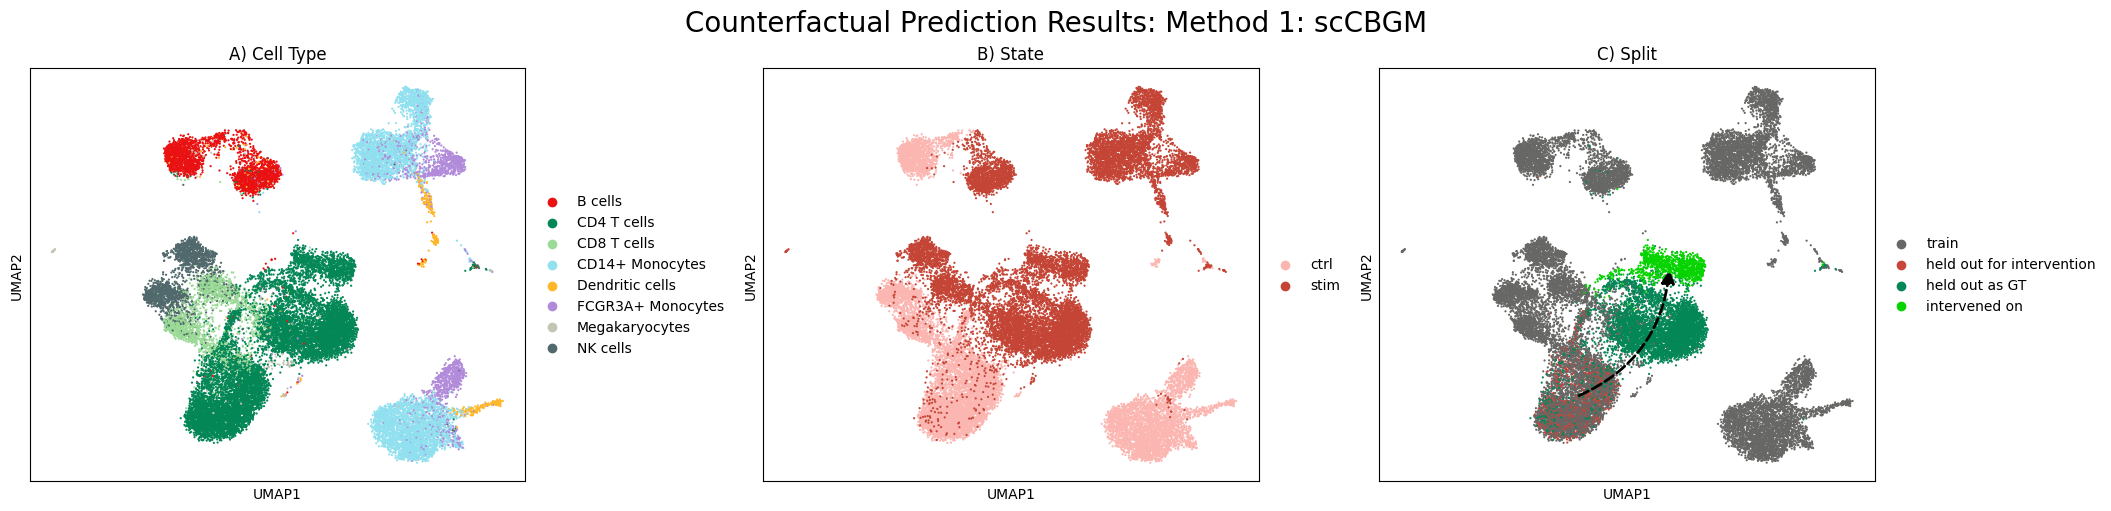

In [17]:
analyze_and_plot_results(adata, pred_adata_cbgm, adata_test, "Method 1: scCBGM")

## --- Method 2: CB-FM with Learned Concepts ---


In [18]:
adata_with_concepts = get_learned_concepts(cbgm_model, adata.copy())
# Distribute the newly generated concepts to the training set
adata_train.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_known']
adata_train.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_unknown']
adata_inter.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_known']
adata_inter.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_unknown']

Generating learned concepts from scCBGM...


In [19]:
fm_learned_model = train_method_2_fm_learned(adata_train.copy())

Training CB-FM model with learned concepts...
Training FM for 1000 epochs with batch size 128...


Epoch 1000/1000 | Loss: 0.5855: 100%|███████████████| 1000/1000 [10:10<00:00,  1.64it/s]


In [20]:
pred_adata_fm_learned = predict_with_method_2_fm_learned(fm_learned_model, adata_inter.copy(), hold_out_label)

Performing intervention with CB-FM (learned)...
Generating 1019 counterfactual sample(s) from 1019 original data point(s) with 1019 counterfactual condition(s).
Applying Classifier-Free Guidance with w_cfg=1.2.
Encoding: Integrating backward to t=0.10...


Encoding (Backward): 100%|███████████████████████████| 900/900 [00:01<00:00, 594.34it/s]


Decoding: Integrating forward to t=1.0 with new condition and noise 0.3...


Decoding (Forward): 100%|████████████████████████████| 900/900 [00:01<00:00, 594.23it/s]


Analyzing and plotting results for Method 2: CB-FM (Learned Concepts)...


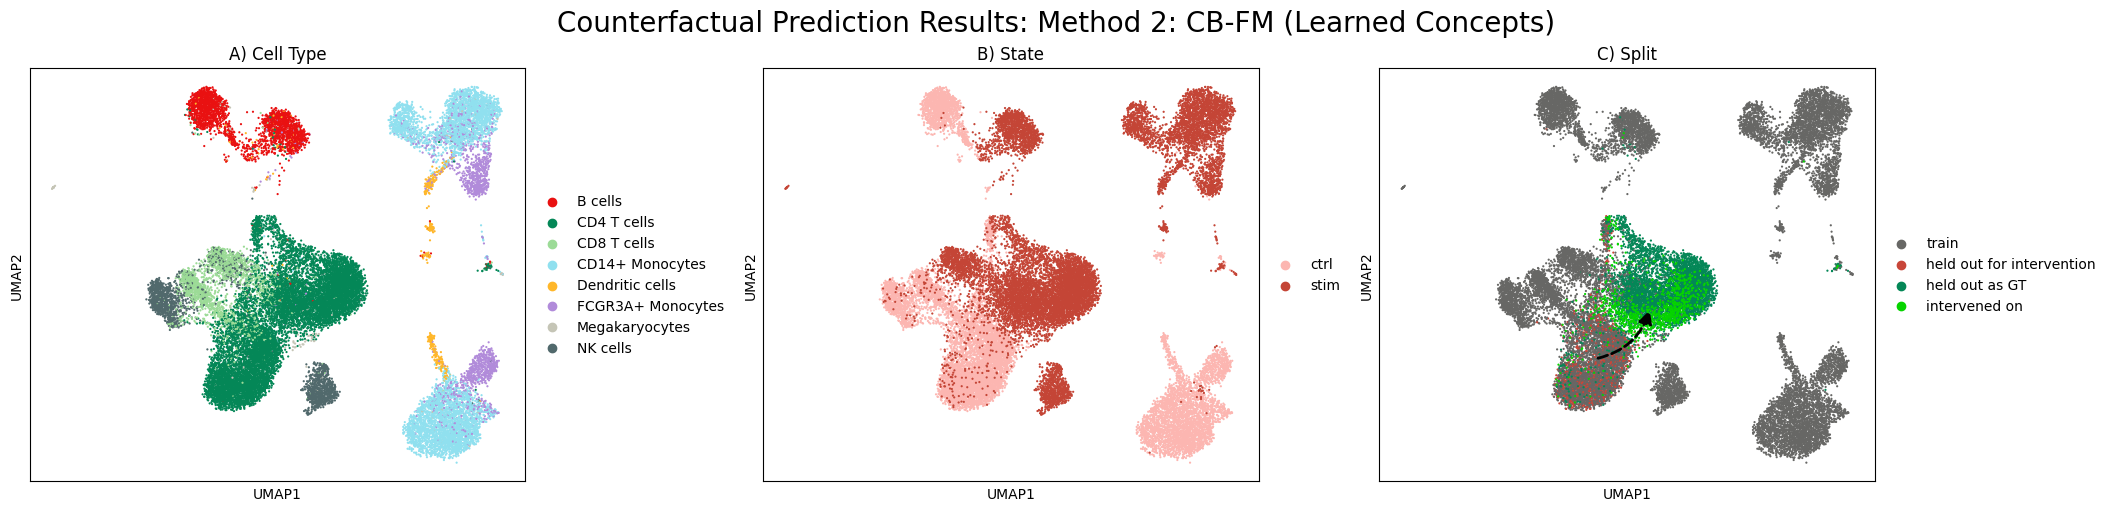

In [21]:
analyze_and_plot_results(adata, pred_adata_fm_learned, adata_test, "Method 2: CB-FM (Learned Concepts)")

## --- Method 3: CB-FM with Raw Concepts ---


In [25]:
fm_raw_model = train_method_3_fm_raw(adata_train.copy())

Training CB-FM model with learned concepts...
Training CB-FM model with raw concepts...
Training FM for 1000 epochs with batch size 128...


Epoch 1000/1000 | Loss: 0.5853: 100%|███████████████| 1000/1000 [08:51<00:00,  1.88it/s]


In [26]:
pred_adata_fm_raw = predict_with_method_3_fm_raw(fm_raw_model, adata_inter.copy(), hold_out_label)

Performing intervention with CB-FM (raw)...
Generating 1019 samples with CFG, w_pos=1


Sampling: 100%|████████████████████████████████████| 1000/1000 [00:01<00:00, 617.15it/s]


Analyzing and plotting results for Method 3: CB-FM (Raw Concepts)...


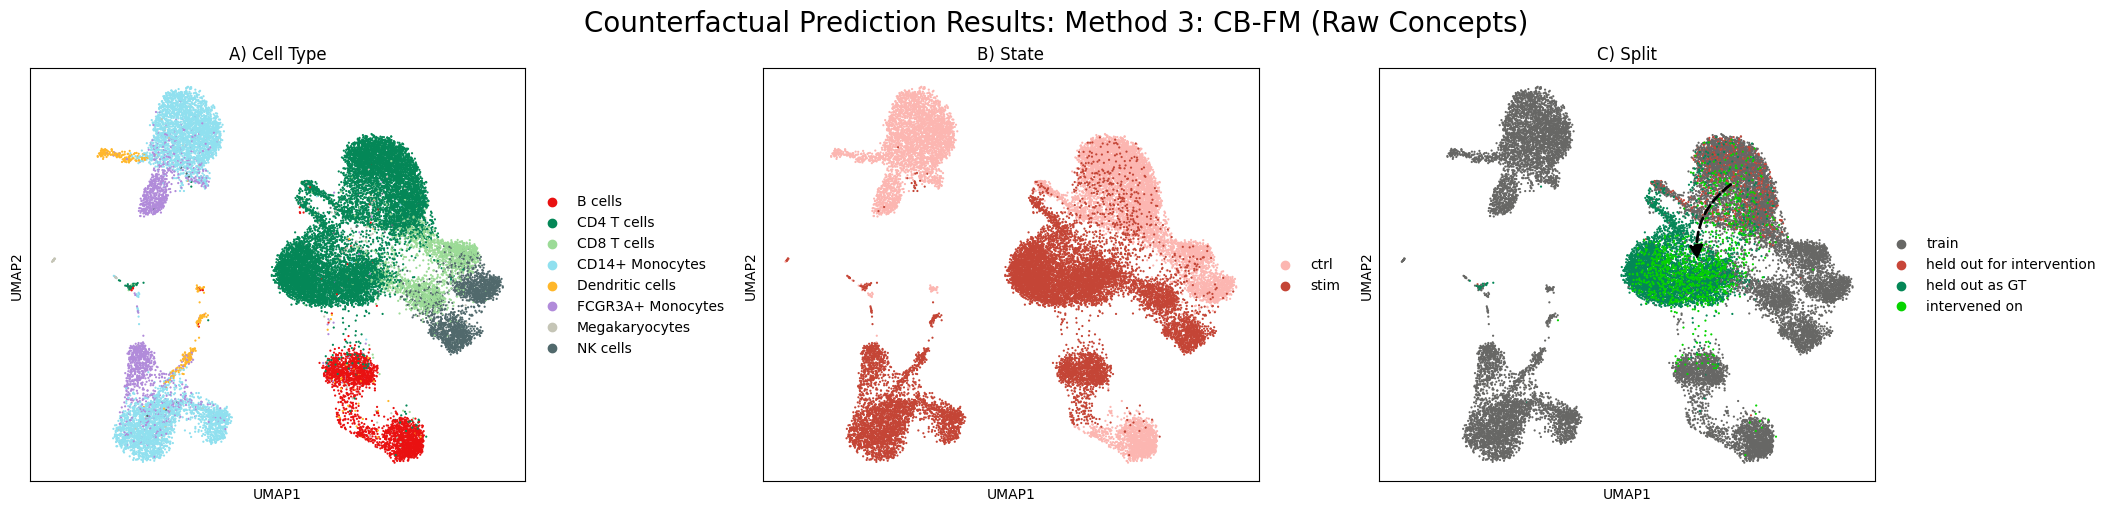

In [27]:
analyze_and_plot_results(adata, pred_adata_fm_raw, adata_test, "Method 3: CB-FM (Raw Concepts)")

## --- Method 4: Cinema OT

In [64]:
#concatenate adata
import pertpy as pt

def predict_with_cot(adata_train, adata_inter, hold_out_label, thresh = 0.5, eps = 0.001):
    #adata_train_stim = adata_train[adata_train.obsm[CONCEPT_KEY]["stim"].values == 1] # taking only stimulated cells
    assert (adata_inter.obsm[CONCEPT_KEY]["stim"].values == 0).all() # Check that all cells to be predicted are not stimulated

    adata_cat = adata_train.concatenate(adata_inter)
    adata_cat.obs["stim"] = adata_cat.obsm["concepts"]["stim"]
    adata_cat.obs["split_col"] = ["train"] * len(adata_train) + ["int"] * len(adata_inter)

    cot = pt.tl.Cinemaot()
    sc.pp.pca(adata_cat)

    de = cot.causaleffect(
                    adata_cat,
                    pert_key="stim",
                    control=0,
                    return_matching=True,
                    thres=thresh,
                    smoothness=1e-5,
                    eps=eps,
                    solver="Sinkhorn",
                    )

    ot_map = de.obsm["ot"] # treatment vs controls

    adata_control = adata_cat[adata_cat.obs["stim"].values == 0]
    adata_treated = adata_cat[adata_cat.obs["stim"].values == 1]

    test_controls_idx = (adata_control.obs["split_col"].values == "int") & (adata_control.obs["stim"].values == 0)
    ot_map_test = ot_map[:,test_controls_idx].T
    ot_map_test /= ot_map_test.sum(1).mean()

    adata_test_control = adata_control[test_controls_idx] # control units to predict

    adata_test_predicted = adata_control[test_controls_idx].copy()
    adata_test_predicted.X = ot_map_test @ adata_treated.X # predicted treated units


    adata_test_predicted.obs['ident'] = 'intervened on'
    adata_test_predicted.obs['cell_stim'] = hold_out_label + '*'

    return adata_test_predicted

In [66]:
adata_test_predicted = predict_with_cot(adata_train,
                                        adata_inter,
                                        hold_out_label,
                                        thresh = 0.5,
                                        eps = 0.001)

/tmp/ipykernel_1271001/870378034.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_cat = adata_train.concatenate(adata_inter)
/homefs/home/debroue1/projects/conceptlab/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Analyzing and plotting results for Method 4: CinemaOT...


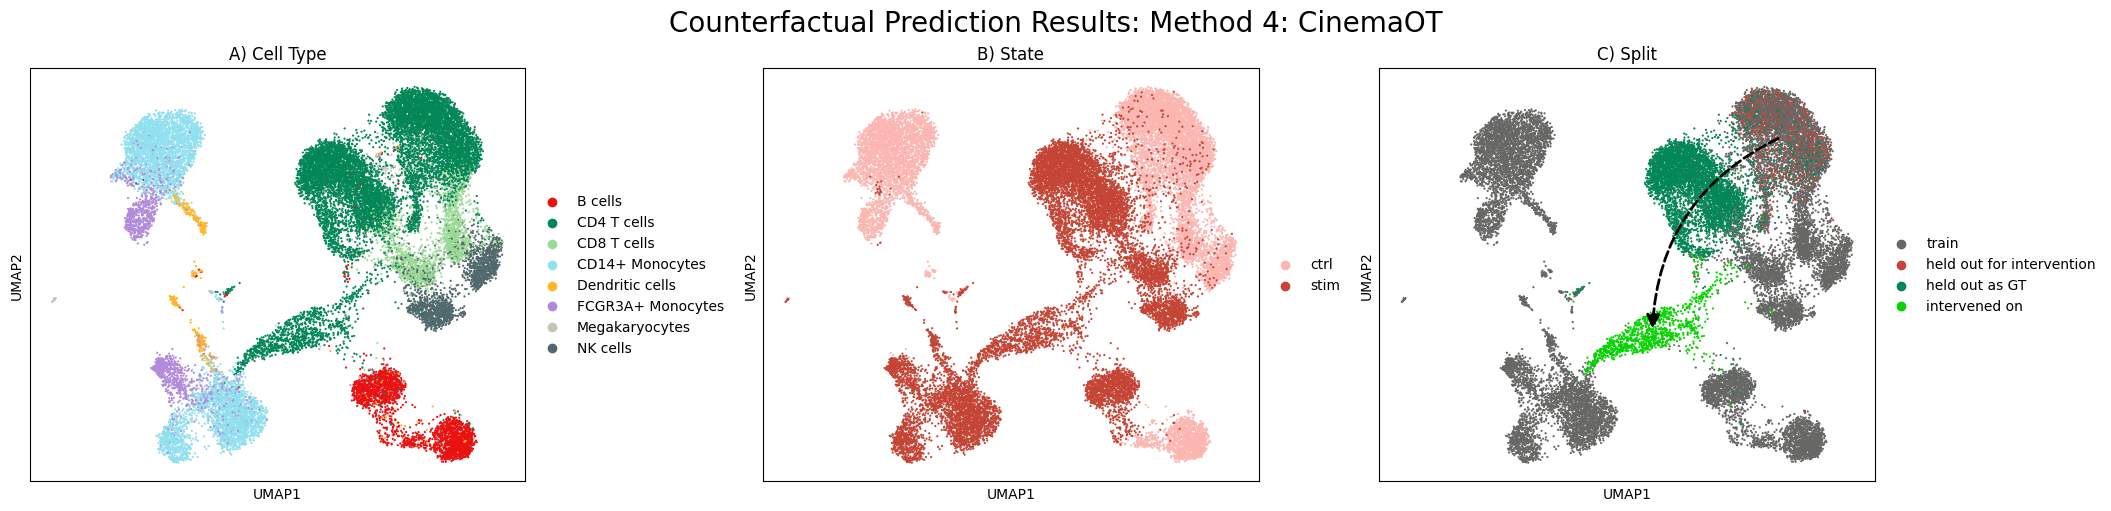

In [67]:
analyze_and_plot_results(adata, adata_test_predicted, adata_test, "Method 4: CinemaOT")

# Benchmark

In [ ]:
# # pc_transform = sklearn.decomposition.PCA(n_components=128).fit(adata_train.X.toarray())


# score_cbfm_learned = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
#     x_train = pc_transform.transform(adata_train.X.toarray()),
#     x_ivn =  pc_transform.transform(pred_adata_cbgm.X),
#     x_target =  pc_transform.transform(adata_test.X.toarray()),
#     labels_train = adata_train.obs['cell_stim'].values
# )

# score_fm_raw = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
#     x_train =  pc_transform.transform(adata_train.X.toarray()),
#     x_ivn =  pc_transform.transform(pred_adata_fm_raw.X),
#     x_target =  pc_transform.transform(adata_test.X.toarray()),
#     labels_train = adata_train.obs['cell_stim'].values
# )

# score_fm_learned = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
#     x_train =  pc_transform.transform(adata_train.X.toarray()),
#     x_ivn =  pc_transform.transform(pred_adata_fm_learned.X),
#     x_target =  pc_transform.transform(adata_test.X.toarray()),
#     labels_train = adata_train.obs['cell_stim'].values
# )




In [ ]:
score_cbfm_learned = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train = adata_train.X.toarray(),
    x_ivn = pred_adata_cbgm.X,
    x_target = adata_test.X.toarray(),
    labels_train = adata_train.obs['cell_stim'].values
)

score_fm_raw = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train = adata_train.X.toarray(),
    x_ivn = pred_adata_fm_raw.X,
    x_target = adata_test.X.toarray(),
    labels_train = adata_train.obs['cell_stim'].values
)

score_fm_learned = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train = adata_train.X.toarray(),
    x_ivn = pred_adata_fm_learned.X,
    x_target = adata_test.X.toarray(),
    labels_train = adata_train.obs['cell_stim'].values
)

In [28]:
score_fm_raw = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train = adata_train.X.toarray(),
    x_ivn = pred_adata_fm_raw.X,
    x_target = adata_test.X.toarray(),
    labels_train = adata_train.obs['cell_stim'].values
)

In [ ]:
# score_fm_learned = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
#     x_train = adata_train.X.toarray(),
#     x_ivn = pred_adata_fm_learned.X,
#     x_target = adata_test.X.toarray(),
#     labels_train = adata_train.obs['cell_stim'].values
# )

In [22]:
score_cbfm_learned

{'mmd_ratio': np.float64(0.8501181243605229),
 'pre_computed_mmd_train': np.float64(0.015308869475714193)}

In [29]:
score_fm_raw

{'mmd_ratio': np.float64(0.47275791778821086),
 'pre_computed_mmd_train': np.float64(0.015308869475714193)}

In [24]:
score_fm_learned

{'mmd_ratio': np.float64(0.3239347987652151),
 'pre_computed_mmd_train': np.float64(0.015308869475714193)}